In [26]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [27]:
def add_arrow(line, position=None, direction='right', size=15, color=None):
    """
    add an arrow to a line. -- code cribbed from http://stackoverflow.com/questions/34017866/arrow-on-a-line-plot-with-matplotlib

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if position is None:
        position = xdata.mean()
    # find closest index
    start_ind = np.argmin(np.absolute(xdata - position))
    if direction == 'right':
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1

    line.axes.annotate('',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle="->", color=color),
        size=size)
                       
    line.axes.annotate('',
        xytext=(xdata[0], ydata[0]),
        xy=(xdata[1], ydata[1]),
        arrowprops=dict(arrowstyle="]-", color=color),
        size=size/3)

## Numerics and analysis of two interacting populations in continuous time
### Erol Akcay

Department of Biology, University of Pennsylvania

Bio 417 Spring 2019


In this notebook, we will draw some graphs to analyze a two-dimensional dynamical system, find its equilibria and use linear stability analysis to determine their stability.

In [28]:
from scipy import integrate 
from scipy import optimize

Let's define the function for the dynamics, like we did in the one-dimensional case: the only difference here is that the state variable (the first argument of the function) is now an array, and the output is also an array, with each element giving the rate of change for each state variable. The second variable again is time (required for the odeint solver we'll use), followed by all the parameters.

In [29]:
def lvcomp(n,t,r1,r2,k1,k2,a,b):
    return np.array([r1*n[0]*(k1-n[0]-a*n[1])/k1, r2*n[1]*(k2-n[1]-b*n[0])/k2])

In [30]:
lvcomp([6,6],0,1,1,10,10,.5,.6)

array([0.6 , 0.24])

Define the jacobian function, i.e.:
$$
\left(\begin{array}{cc}
\frac{\partial f_{N_1}}{\partial N_1}&\frac{\partial f_{N_1}}{\partial {N_2}}\\
\frac{\partial f_{N_2}}{\partial {N_1}}&\frac{\partial f_{N_2}}{\partial {N_2}}\end{array}\right)
$$

In [31]:
def lvcompjac(n,t,r1,r2,k1,k2,a,b):
    return np.array([[
            (k1-2*n[0]-a*n[1])*r1/k1, - a*n[0]*r1/k1],
            [-b*n[1]*r2/k2, (k2-b*n[0]-2*n[1])*r2/k2]
        ])

In [32]:
lvcompjac([5,5],0,1,1,10,10,.5,.6)

array([[-0.25, -0.25],
       [-0.3 , -0.3 ]])

Below, we use the optimize.root() function to find the equilibrium of the system. Root solves for the values of the state variables that make a given  function equal to zero. It returns an OptimizeResult object, which includes information about the location of the root.

In [33]:
eqn = optimize.root(lvcomp,[8,9], args=(0,1,1,10,20,.2,.9))

This gives the location of the root that's found.

In [34]:
eqn.x

array([ 7.31707317, 13.41463415])

In [35]:
lvcomp(eqn.x,0,1,1,10,20,.2,.9)

array([-8.73772599e-13,  1.17364655e-11])

Note that the root finder algorithms are local algorithms, that is, they start with the initial values you give them (the second argument in optimize.root() and work towards the "nearest" root. This means that if there are multiple roots of the function (as is frequently the case), you may converge to one or the other. 

Now that we have a root, we can compute the jacobian at that root.

In [36]:
lvcompjac(eqn.x,0,1,1,10,20,.2,.9)

array([[-0.73170732, -0.14634146],
       [-0.60365854, -0.67073171]])

In [37]:
np.linalg.eig(lvcompjac(eqn.x,0,1,1,10,10,.2,.9))

(array([-0.62856046, -2.44461027]), array([[ 0.81737029,  0.08512466],
        [-0.57611268,  0.99637031]]))

In [38]:
timevec = np.linspace(0,50,1000)
traj = integrate.odeint(lvcomp, np.array([5,5]), timevec, args = (1,1,10,20,.2,.9))

In [39]:
n1, n2 = traj.T

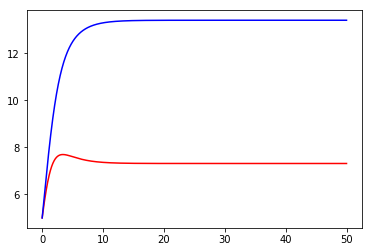

In [40]:
plt.plot(timevec, n1,'r')
plt.plot(timevec, n2,'b')

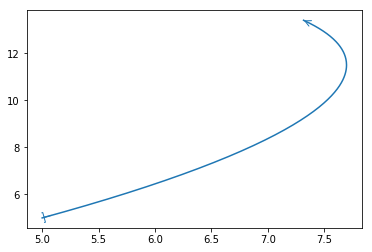

In [41]:
n1, n2 = traj.T
traplot = plt.plot(n1,n2)[0]
add_arrow(traplot)

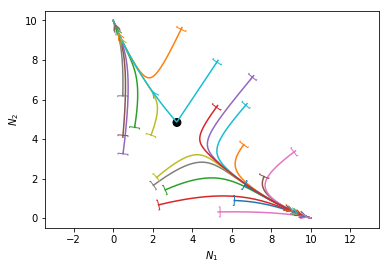

In [51]:
params = (1,1,10,10,1.4,1.6)
eqn = optimize.root(lvcomp,[7,9], args= (0,)+params)
for i in range(20):
    traj = integrate.odeint(lvcomp, np.array(np.random.rand(2)*10), timevec, args = params)
    n1, n2 = traj.T
    traplot = plt.plot(n1,n2)[0]
    add_arrow(traplot)
eqpoint = plt.Circle(eqn.x, .2, color='black', fill=True)
plt.gca().add_patch(eqpoint)
plt.axes().set_aspect('equal', 'datalim')
plt.xlabel('$N_1$')
plt.ylabel('$N_2$')
plt.show()

Calculate the jacobian, and see that one of the eigenvalues is positive.

In [52]:
dum = (eqn.x,0)+params # create a tuple using the tuple params in the required format for inputting into lvcompjac
np.linalg.eig(lvcompjac(*dum))

(array([ 0.19354839, -1.        ]), array([[ 0.65850461,  0.5547002 ],
        [-0.75257669,  0.83205029]]))

#### LV Prey-predator dynamics

Now let's look at another fundamental ecological interaction: dynamics of prey and predator

In [18]:
def lvpreypred(n,t,r,a,b,d):
    return np.array([(r-a*n[1])*n[0], (b*n[0]-d)*n[1]])

In [19]:
eqn = optimize.root(lvpreypred,[8,9], args=(0,1,0.2,0.1,1))
eqn.x

array([10.,  5.])

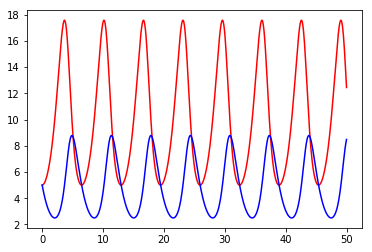

In [20]:
timevec = np.linspace(0,50,1000)
traj = integrate.odeint(lvpreypred, np.array([5,5]), timevec, args=(1,0.2,0.1,1))
vv, pp = traj.T
plt.plot(timevec,vv,'r')
plt.plot(timevec,pp,'b')

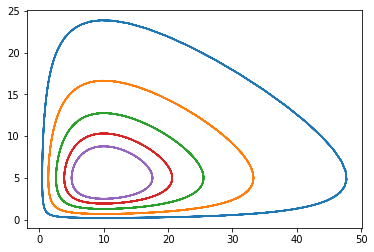

In [21]:
for i in range(5):
    traj = integrate.odeint(lvpreypred, np.array([i+1,i+1]), timevec, args=(1,0.2,0.1,1))
    vv, pp = traj.T
    plt.plot(vv,pp)

So, we have neutrally stable cycles, i.e., the population keeps staying on a given cycle that's completely determined by the initial conditions.

Let's check the Jacobian. But instead of writing a new function for the jacobian of every dynamics, let's write a function that symbolically differentiates the dynamics and computes the value.

In [22]:
import sympy as sym
v = sym.symbols('v')
p = sym.symbols('p')

In [23]:
def jacob(fun, n1, n2, argum=(),initval=[5,6]):
    dum = ([n1,n2],)+argum
    eq = optimize.root(fun,initval,args=argum) #find the equilibrium, may need playing around with initval
    dum1, dum2 = fun(*dum)
    jaco = [[sym.diff(dum1,n1),sym.diff(dum1,n2)],
                  [sym.diff(dum2,n1),sym.diff(dum2,n2)]] #symbolically evaluate the derivatives
    jaco = np.asarray([[jaco[i][j].subs([(n1,eq.x[0]),(n2,eq.x[1])]) for j in range(2)] for i in range(2)])# substitute the equilibrium values
    return [eq.x, jaco.astype(np.float64)]

In [24]:
equ, jack = jacob(lvpreypred,v,p,argum=(2,1,.1,.1,1),initval=[8,10])
jack

array([[ 0., -1.],
       [ 1.,  0.]])

In [25]:
np.linalg.eig(jack)

(array([0.+1.j, 0.-1.j]),
 array([[0.70710678+0.j        , 0.70710678-0.j        ],
        [0.        -0.70710678j, 0.        +0.70710678j]]))

Let's add density dependence of the prey now.

In [26]:
def lvpreypredDD(n,t,r,a,b,d,k):
    return np.array([(r*(k-n[0])/k-a*n[1])*n[0], (b*n[0]-d)*n[1]])

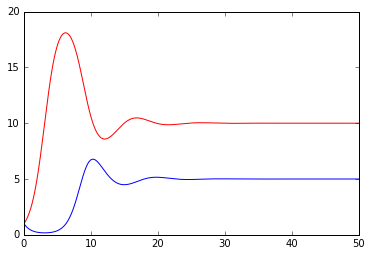

In [27]:
timevec = np.linspace(0,50,1000)
traj = integrate.odeint(lvpreypredDD, np.array([1,1]), timevec, args=(1,0.1,0.1,1,20))
vv, pp = traj.T
plt.plot(timevec,vv,'r')
plt.plot(timevec,pp,'b')

Now we seem to have (oscillatory) convergence to a stable equilibrium. Let's check the stability of this equilibrium with the Jacobian. 

In [28]:
equ, jack = jacob(lvpreypredDD,v,p,argum=(2,1,.1,.1,1,20),initval=[16,10])
jack

array([[ -5.00000000e-01,  -1.00000000e+00],
       [  5.00000000e-01,   7.79376563e-14]])

In [29]:
equ

array([ 10.,   5.])

In [30]:
np.linalg.eig(jack)

(array([-0.25+0.66143783j, -0.25-0.66143783j]),
 array([[ 0.81649658+0.j        ,  0.81649658-0.j        ],
        [-0.20412415-0.54006172j, -0.20412415+0.54006172j]]))

In [31]:
def lvpreypredTT(n,t,r,a,b,d,h):
    return np.array([(r-a*n[1]/(n[0]+h))*n[0], (b*n[0]/(n[0]+h)-d)*n[1]])

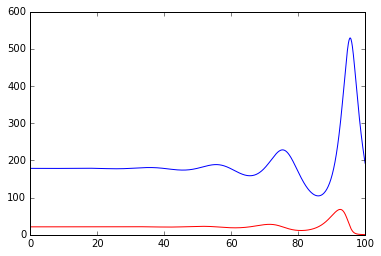

In [32]:
timevec = np.linspace(0,100,1000)
traj = integrate.odeint(lvpreypredTT, np.array([21.4,178.57]), timevec, args=(.5,0.2,1,.3,50))
vv, pp = traj.T
plt.plot(timevec,vv,'r')
plt.plot(timevec,pp,'b')

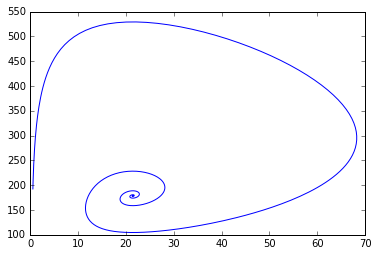

In [33]:
plt.plot(vv,pp)

In [34]:
equ, jack = jacob(lvpreypredTT,v,p,argum=(0,.5,0.2,1,.3,50),initval=[100,1000])

In [35]:
equ

array([  21.42857143,  178.57142857])

In [36]:
np.linalg.eig(jack)

(array([ 0.075+0.31523801j,  0.075-0.31523801j]),
 array([[ 0.04214082+0.17712516j,  0.04214082-0.17712516j],
        [ 0.98328573+0.j        ,  0.98328573-0.j        ]]))